In [1]:
%matplotlib inline

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import itertools


def plot_accnloss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    tick_marks = [0, 1]
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
get_val = lambda arr: list(map(lambda x: x[1], arr))
print('')

In [2]:
import numpy as np
import pandas as pd
import pathlib

# from attention import AttentionWithContext

import time, sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# from keras.models import Sequential, Model, load_model
# from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Embedding, LSTM, Input
# from keras.layers import Activation, Dropout, Flatten, Bidirectional, TimeDistributed, Reshape
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras import optimizers, utils, regularizers
# from keras import backend as K
# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.tensorflow_backend.set_session(tf.Session(config=config))

import dill as pickle

[x_train, x_test, y_train, y_test] = np.load('../dataset/train_test_data.npy')
x_train = x_train.astype('int32')
x_test = x_test.astype('int32')
print(x_train.shape, y_train.shape)
print(x_train.dtype, y_train.dtype)
print(x_test.shape, y_test.shape)
print(x_test.dtype, y_test.dtype)

print(f'pos size = { len(y_test[np.where( y_test[:,0] == 0 )]) }')
print(f'neg size = { len(y_test[np.where( y_test[:,0] == 1 )]) }')

word_vec = np.load('../model/vec.npy')

# print(K.floatx()) # should equal float32

Using TensorFlow backend.


(34912, 600) (34912, 2)
int32 int32
(6161, 600) (6161, 2)
int32 int32
pos size = 3224
neg size = 2937
float32


In [3]:
from gensim.models import KeyedVectors
from collections import defaultdict as ddict
pad_token = x_train[0][-1]
x_train = np.array(list(map(lambda x: np.array(list(filter(lambda e: e!=pad_token, x))) , x_train)))
x_test = np.array(list(map(lambda x: np.array(list(filter(lambda e: e!=pad_token, x))) , x_test)))
vector_model_dir = '../model/'
vector_model_path_bin = f'{vector_model_dir}vec.bin'
vector_model = KeyedVectors.load_word2vec_format(vector_model_path_bin, binary=True)

itos = vector_model.index2word
# stoi = ddict(lambda: 0, {v:k for k,v in enumerate(itos)})

patt = lambda: [False] * len(itos)
def occ(x):
    res = patt()
    for i in x:
        res[i] = True
    return res

import time
start = time.time()

x_train_nb = np.array(list(map(lambda x: occ(x) , x_train[:20000])))
x_test_nb = np.array(list(map(lambda x: occ(x) , x_test)))
print(x_train_nb.shape)

end = time.time()
print(end-start)

# y_train = np.array(get_val(y_train))
# y_true = get_val(y_test)
# y_test = np.array(get_val(y_test))

C:\Users\L\Miniconda3\envs\dev\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(20000, 65000)
35.1932590007782


In [4]:

from sklearn.naive_bayes import GaussianNB

y_train = np.array(get_val(y_train))
y_true = get_val(y_test)
y_test = np.array(get_val(y_test))

# from sklearn import datasets
# iris = datasets.load_iris()
# print(iris.data)
# print(x_train)




gnb = GaussianNB()
y_predict = gnb.fit(x_train_nb, y_train[:20000]).predict(x_test_nb)

end = time.time()
total_time = end-start
print(total_time)

61.08368229866028


              precision    recall  f1-score   support

    negative   0.547418  0.906027  0.682483      2937
    positive   0.787692  0.317618  0.452697      3224

   micro avg   0.598117  0.598117  0.598117      6161
   macro avg   0.667555  0.611822  0.567590      6161
weighted avg   0.673152  0.598117  0.562238      6161

Normalized confusion matrix
[[0.31761787 0.68238213]
 [0.09397344 0.90602656]]


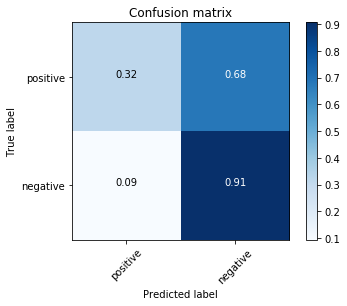

Confusion matrix, without normalization
[[1024 2200]
 [ 276 2661]]


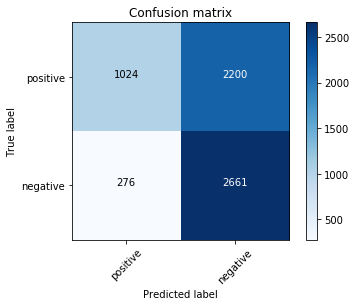

In [5]:

print(metrics.classification_report(y_true, y_predict, target_names = ['negative', 'positive'], digits=6))

plot_confusion_matrix(confusion_matrix(y_true, y_predict, labels=[1,0]), 
                      classes=['positive', 'negative'], 
                      normalize=True,
                      title='Confusion matrix')

plot_confusion_matrix(confusion_matrix(y_true, y_predict, labels=[1,0]), 
                      classes=['positive', 'negative'], 
                      normalize=False,
                      title='Confusion matrix')
